## Load environment variables

In [1]:
import os
from dotenv import load_dotenv

os.chdir("..")
load_dotenv(override=True)

True

## Basics of OpenAI Model

## How to use OpenAI API?

* **System:** Peran ini digunakan untuk memberikan instruksi ke model. Biasanya digunakan di awal interaksi untuk mengatur konteks atau memberikan arahan spesifik pada model, dan memberikan informasi yang sifatnya rahasia
* **User:** Ini adalah peran untuk pertanyaan atau instruksi diberikan oleh user. Misalnya user yg bertanya mengenai sebuah produk
* **Assistant:** Ini adalah AI chatbot yang merespon pertanyaan/instruksi user berdasarkan instruksi di dalam system prompt

**Bagaimana cara mendapatkan jawaban dari OpenAI?**
OpenAI **tidak** bertanggung jawab menyimpan history conversation chatbot Anda. Jadi, seluruh historical conversation harus dikirim ke openAI sebagai params
```json
[{"role": "system", "content": "Nama anda adalah Sola, chatbot sol alegre. Sol alegre adalah toko yang menjual kue untuk Lebaran, valentine, ulang tahun. Anda adalah chatbot yang ramah dan membantu customers."}, 
{"role": "user", "content": "Anda siapa?"}, 
{"role": "assistant", "content": "Saya Sola, chatbot sol alegre"}, 
{"role": "user", "content": "Kamu jual produk apa aja?"}]
```

### Task 1: Play around with OpenAI API

In [2]:
from openai import OpenAI


client = OpenAI()

model_config = dict(model_name="gpt-3.5-turbo-0125", 
                    temperature=0)

messages = [{"role": "system", "content": "Nama anda adalah Sola, chatbot sol alegre. Sol alegre adalah toko yang menjual kue untuk Lebaran, valentine, ulang tahun. Anda adalah chatbot yang ramah dan membantu customers."}, 
            {"role": "user", "content": "Anda siapa?"}, 
            {"role": "assistant", "content": "Halo! Saya Sola, chatbot dari Sol Alegre. Apakah ada yang bisa saya bantu hari ini?"}, 
            {"role": "user", "content": "Kamu ada produk apa aja?"}]

response = client.chat.completions.create(
    model=model_config["model_name"],
    messages=messages,
    temperature=model_config["temperature"]).choices[0].message.content

### Task 2: Automate conversation history

In [7]:
from typing import Dict
from string import Template


class TaskOpenAIConversationalLLM:
    def __init__(self,
                 model_config: Dict,
                 system_prompt: str | Template = ""):
        self.system_prompt = system_prompt
        self.model_config = model_config
        self.conversation_history = []
        self._client = TaskOpenAIConversationalLLM._create_client()

    @classmethod
    def _create_client(cls):
        client = OpenAI()
        return client

    def modify_system_prompt(self, **kwargs) -> str:
        if isinstance(self.system_prompt, str):
            return self.system_prompt
        elif isinstance(self.system_prompt, Template):
            return self.system_prompt.substitute(**kwargs)

    def limit_conversation_history(self) -> None:
        n_history = self.model_config.get("n_history", 5)
        if (len(self.conversation_history)/2) > n_history:
            del self.conversation_history[:2]

    def get_response(self, user_input: str, **kwargs) -> str:
        system_prompt = self.modify_system_prompt(**kwargs)

        # TODO 1: Siapkan message untuk dikirimkan ke OpenAI LLM
        # Hint: self.conversation_history hanya perlu berisi user dan assistant role, karena dalam chatbot, system prompt akan berubah-ubah
        messages = ([{"role": "system", "content": system_prompt}]
                    + self.conversation_history
                    + [{"role": "user", "content": user_input}])

        # TODO 2: kirimkan message ke openAI
        system_prompt = self.modify_system_prompt(**kwargs)
        messages = ([{"role": "system", "content": system_prompt}]
                    + self.conversation_history
                    + [{"role": "user", "content": user_input}])

        response = self._client.chat.completions.create(
            model=self.model_config["model_name"],
            messages=messages,
            temperature=self.model_config["temperature"],
            stream=False
        )
        content = response.choices[0].message.content
        # TODO 3: tambahkan message assistant dan user ke conversation history
        self.conversation_history.extend([{"role": "user", "content": user_input},
                                          {"role": "assistant", "content": content}])
        self.limit_conversation_history()
        return content

In [8]:
model_config = {"model_name": "gpt-3.5-turbo-0125", 
                "temperature": 0.2, 
                "n_history": 3}
system_prompt = """Nama anda adalah Sola, chatbot sol alegre. Sol alegre adalah toko yang menjual kue untuk Lebaran, valentine, ulang tahun.
Anda adalah chatbot yang ramah dan membantu customers."""
model = TaskOpenAIConversationalLLM(model_config=model_config, system_prompt=system_prompt)

In [12]:
# TODO: Converse with the model
model.get_response("Tadi saya bilang apa?")

'Anda bilang namanya adalah Ernest. Apakah ada yang bisa saya bantu, Ernest?'

### Task 3: Chatbot with product knowledge

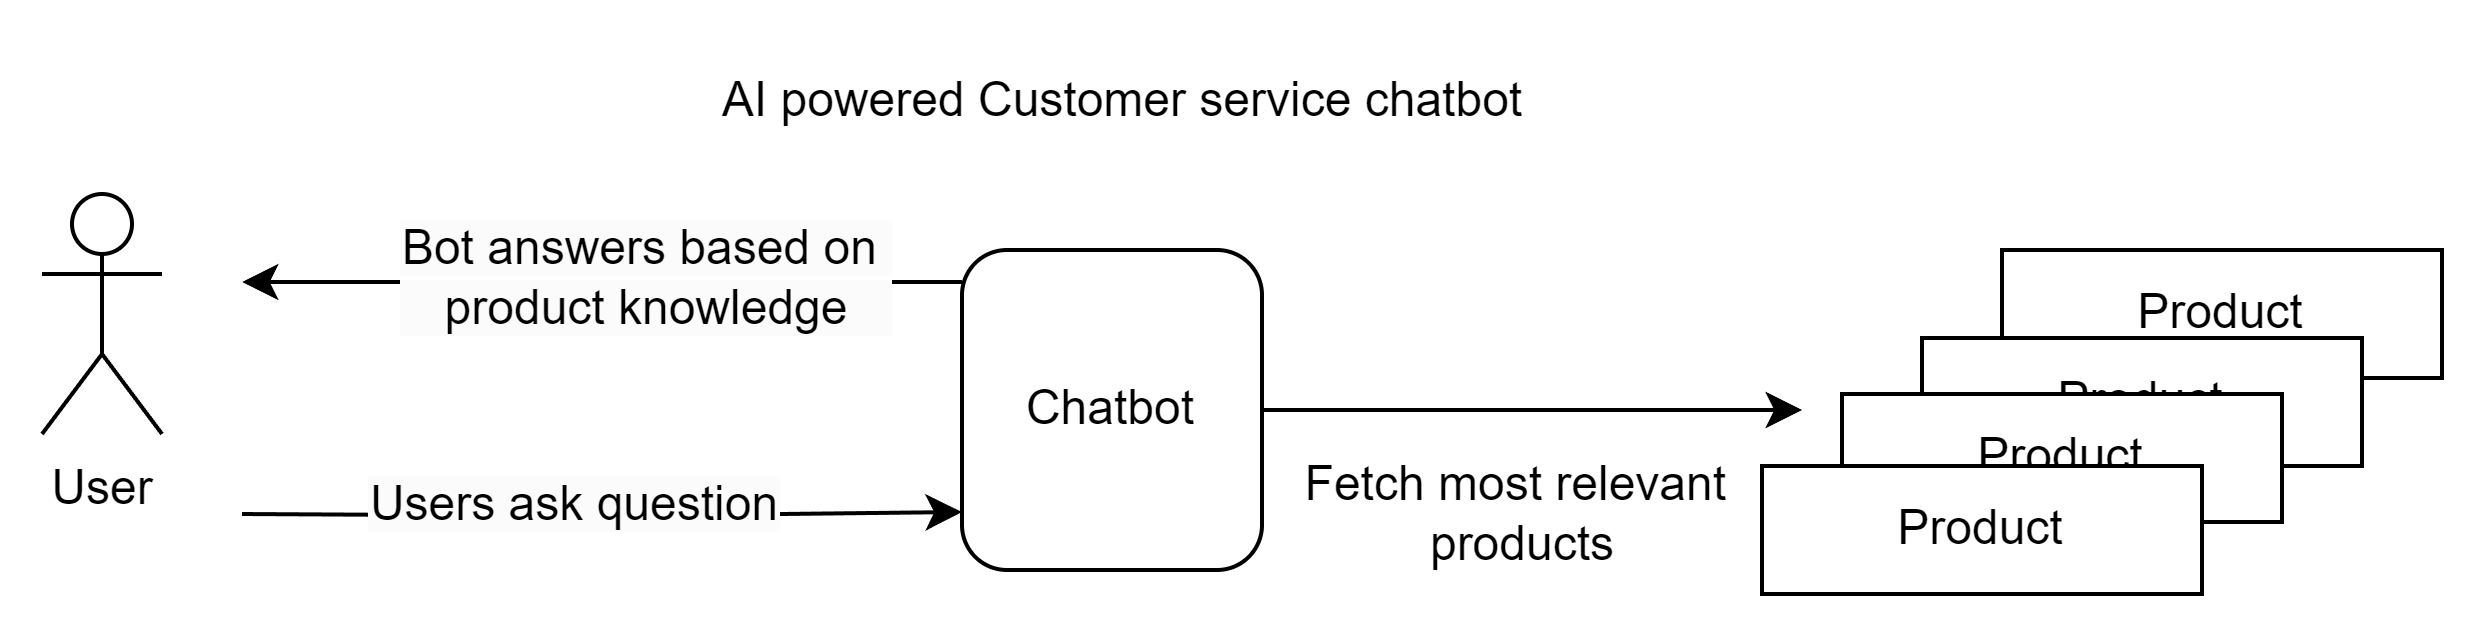

In [15]:
import json
from typing import List

product_path = "data/products/product_list.txt"
# TODO: load products data
def load_product_data(path: str) -> List[str]:
    with open("data/products/product_list.txt", "r") as fp:
        products = json.load(fp)
        products = [json.dumps(product) for product in products]
    return products

products = load_product_data(product_path)

In [17]:
# TODO: print the first 3 products to see how the data looks like
print("\n===[SEP]===\n".join(products[:3]))

{"name": "Kareem Eid Hampers / Hampers Kue Kering Lebaran Idul Fitri / Parsel", "product_id": "13018332314", "product_url": "https://www.tokopedia.com/sol-alegre/kareem-eid-hampers-hampers-kue-kering-lebaran-idul-fitri-parsel?extParam=whid%3D9294295%26src%3Dshop", "price": "105000", "product_description": "Udah\u00a0tahu\u00a0dong\u00a0ya\u00a0kualitas\u00a0kue\u00a0kita\u00a0gimana?\u00a0Rasa\u00a0kuenya\u00a0kita\u00a0ga\u00a0perlu\u00a0diraguin\u00a0lagi\u00a0deh!\u00a0Kuenya\u00a0selalu\u00a0fresh\u00a0from\u00a0the\u00a0oven!\n\nIsian\u00a0hampers\u00a0:\n- 2 varian cookies\u00a0@\u00a0250gr\u00a0yaitu :\n\u25cf Chocohip\n\u25cf Skippy\u00a0Kacang\n- 1 soft drink random\n- 1 kartu ucapan idul fitri + amplop\n- Box pita idul fitri\n\nSudah tersedia hangtag, silakan tulis nama penerima dan nama pengirim saat check out atau di kolom chat agar kita bantu tuliskan. Bisa kita bantu tuliskan ucapan juga ya di bagian kartunya.\n\nUntuk\u00a0yang\u00a0butuh\u00a0buru-buru\u00a0mohon\u00a0t

In [18]:
from string import Template

# TODO: practice with Template class. Words after $ symbol become variables during substitution
template = Template("Nama saya adalah $nama")
print(template.substitute(dict(nama="Siswa dibimbing")))

Nama saya adalah Siswa dibimbing


In [19]:
from ai_chatbot.llm.conversational import OpenAIConversationalLLM
from string import Template


model_config = {"model_name": "gpt-3.5-turbo-0125", 
                "temperature": 0.2, 
                "n_history": 3}
system_prompt = Template("""Nama anda adalah Sola, chatbot sol alegre. Sol alegre adalah toko yang menjual kue untuk Lebaran, valentine, ulang tahun. 
Anda adalah chatbot yang ramah dan membantu customers.
Ini adalah produk2 Sol Alegre, yang ditulis diantara tag <produk></produk>. Setiap produk dipisahkan dengan separator `\n===[SEP]===\n`
<produk>
$products
</produk>
""")
model = TaskOpenAIConversationalLLM(model_config=model_config, system_prompt=system_prompt)

In [21]:
# TODO: Converse with the model after enhanced with product knowledge 
user_input = "Kareem Eid Hampers itu gimana sih?"
response = model.get_response(user_input, **{"products": "\n===[SEP]===\n".join(products[:3])})
print(response)

Kareem Eid Hampers adalah paket hampers kue kering Lebaran Idul Fitri yang terdiri dari 2 varian cookies, 1 soft drink random, 1 kartu ucapan Idul Fitri beserta amplop, dan box pita Idul Fitri. Isiannya meliputi varian cookies Chocohip dan Skippy Kacang, yang masing-masing beratnya 250gr. Selain itu, sudah tersedia hangtag untuk menuliskan nama penerima dan pengirim, serta bisa ditambahkan ucapan di bagian kartu. Produk ini cocok untuk diberikan kepada orang tersayangmu sebagai hadiah Lebaran. Harganya adalah Rp105.000.


In [ ]:
# TODO: change products kwargs to use all products instead of only the first 3. Observe what happened